## Parts of Speech Tagging & Named Entity Recognition

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
sentence = 'London is the capital and most populous city of England.'
# sentence = post
sentence_nlp = nlp(sentence)

In [ ]:
from spacy import displacy
displacy.render(sentence_nlp, jupyter=True,
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [ ]:
# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(London, 'GPE'), (England, 'GPE')]


# Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import re
import unicodedata

In [ ]:
url = 'https://github.com/EunCheolChoi0123/COMM557Tutorial/raw/main/Tutorial%204%20NLP%20(1)%20Sentiment%20Analysis/rdatascience_submission_comments_df.csv'
df  = pd.read_csv(url)
df = df[~df.body.isna()]

df['body'] = df['body'].astype('str')
df['body']

,body
0,Some cities will have data science heavy roles...
1,"> My first idea was the customer churn, as it ..."
2,One thing to consider is the distribution of y...
3,"I got my Masters in IO, first job in the field..."
4,It doesn't really matter. Data science work ex...
...,...
574,Yea lol mfer want sympathy for that making cash.
575,"Nah, working in office after being used to poo..."
576,Okay that is something I can relate to wholehe...
577,2 SD is quite strict. Especially in cases with...


In [ ]:
# remove HTML links and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def process_posts(post):
    post = strip_links(post)
    post = remove_special_characters(post)
    return post

df.loc[:, 'body'] = df.body.apply(process_posts)

In [ ]:
text = ' '.join(df.body.tolist()).lower()

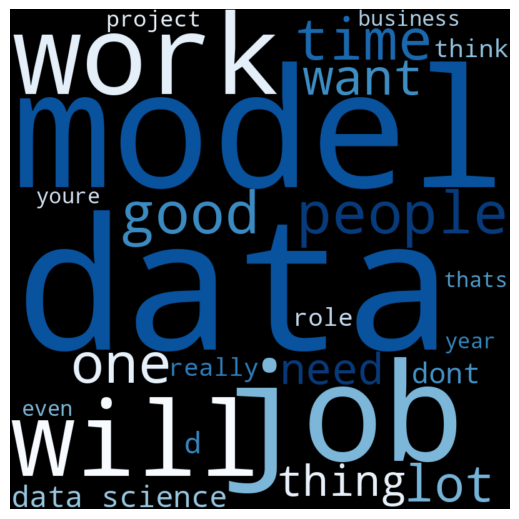

In [ ]:
# create the wordcloud object
wordcloud = WordCloud(width = 800, height = 800,
                #background_color ='white',
                stopwords = STOPWORDS,
                max_words=25,
                colormap='Blues', # Blues
                collocations = True,
                prefer_horizontal=1.0,
                min_font_size = 10).generate(text)

# plot word cloud
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.margins(x=0, y=0)
plt.axis("off")
plt.tight_layout(pad = 0)

# Semantic Network

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
from datetime import datetime
import re
import string
from collections import Counter
import itertools
import networkx as nx
import unicodedata
import random
from gensim import corpora

### Load Twitter data

In [ ]:
df['body'] = df['body'].astype('str')
df['body']

,body
0,Some cities will have data science heavy roles...
1,My first idea was the customer churn as it ap...
2,One thing to consider is the distribution of y...
3,I got my Masters in IO first job in the field ...
4,It doesnt really matter Data science work exis...
...,...
574,Yea lol mfer want sympathy for that making cash
575,Nah working in office after being used to poop...
576,Okay that is something I can relate to wholehe...
577,2 SD is quite strict Especially in cases with ...


In [ ]:
df = df[~df.body.isna()]

### Preprocessing Twitter Data

In [ ]:
# remove HTML links and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [ ]:
def process_posts(post):
    post = strip_links(post)
    post = remove_special_characters(post)
    return post

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df.loc[:, 'body'] = df.body.apply(process_posts)
df.body

,body
0,Some cities will have data science heavy roles...
1,My first idea was the customer churn as it ap...
2,One thing to consider is the distribution of y...
3,I got my Masters in IO first job in the field ...
4,It doesnt really matter Data science work exis...
...,...
574,Yea lol mfer want sympathy for that making cash
575,Nah working in office after being used to poop...
576,Okay that is something I can relate to wholehe...
577,2 SD is quite strict Especially in cases with ...


### Stemming/Lemming

In [ ]:
# Stemming / Lemming

### loading a spacy language model
# python -m spacy download en_core_web_sm
# https://spacy.io/models/en

nlp = spacy.load('en_core_web_sm')

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [ ]:
post = df['body'][30]

print(post)
print('------\nstemmed post:')
print(simple_stemmer(post))
print('------\nlemmatized post:')
print(lemmatize_text(post))

Have you tried using SMOTE or something to generate synthetic examples of the less represented classes
------
stemmed post:
have you tri use smote or someth to gener synthet exampl of the less repres class
------
lemmatized post:
have you try use SMOTE or something to generate synthetic example of the less represented class


### Tokenizing and Corpus Creation

In [ ]:
### Run this the first time
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
%%time
#Create corupus of all words
words_corpus = []
for elem in df.body:
    # remove stop words
    elem = remove_stopwords(elem)
    # lemmatize text
    elem = lemmatize_text(elem)
    words_corpus.append(elem.lower().split())
print(len(words_corpus))

dictionary = corpora.Dictionary(words_corpus)
print(len(dictionary))

579
3350
CPU times: user 7.98 s, sys: 4.33 ms, total: 7.99 s
Wall time: 8.1 s


#### Apply this to the entire dataframe

In [ ]:
%%time
df["text_processed"] = df.body.apply(remove_stopwords)
df["text_processed"] = df.text_processed.apply(lemmatize_text)
df["text_processed"] = df.text_processed.apply(lambda x: x.lower().split())

CPU times: user 5.92 s, sys: 2.52 ms, total: 5.92 s
Wall time: 5.95 s


# RUN UNTIL HERE TO FOLLOW DURING CLASS

In [ ]:
df["text_tups"] = df.text_processed.apply(lambda x: list(itertools.combinations(x, 2)))
all_tups = [item for sublist in df.text_tups.values for item in sublist]
all_tups = Counter(all_tups)

In [ ]:
word_edges = all_tups.most_common(1000)
word_edges = [(w[0][0], w[0][1], w[1] ) for w in word_edges]

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(word_edges)

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_component = connected_components[0]
G = G.subgraph(largest_component)

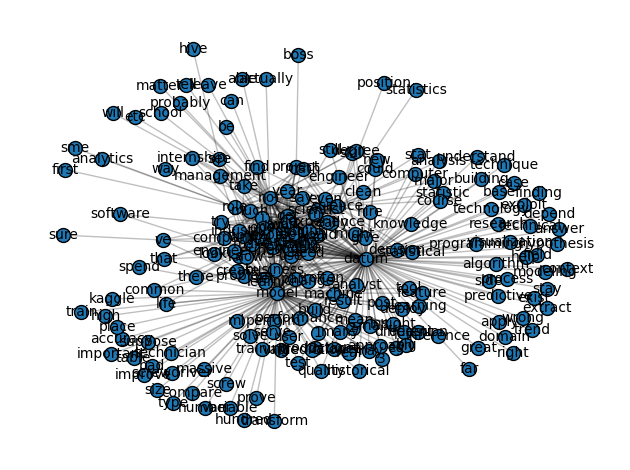

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=200)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)
nx.draw_networkx_nodes(G, pos, node_size=100).set_edgecolor('black')

# Add labels to the nodes
labels = {node: str(node) for node in G.nodes()}  # Replace str(node) with your actual labels
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

plt.tight_layout()
plt.axis("off")
plt.show()

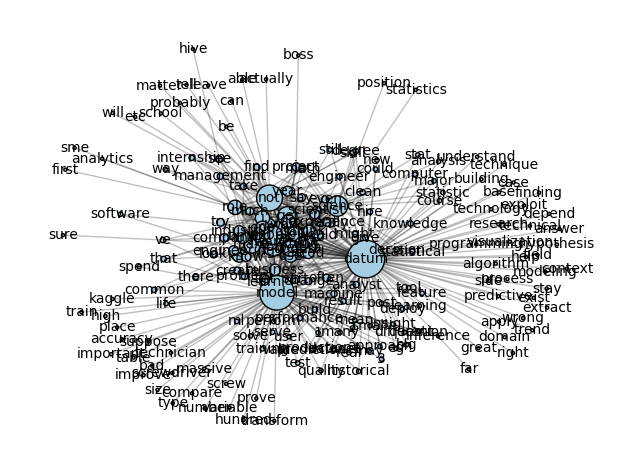

In [ ]:
degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()

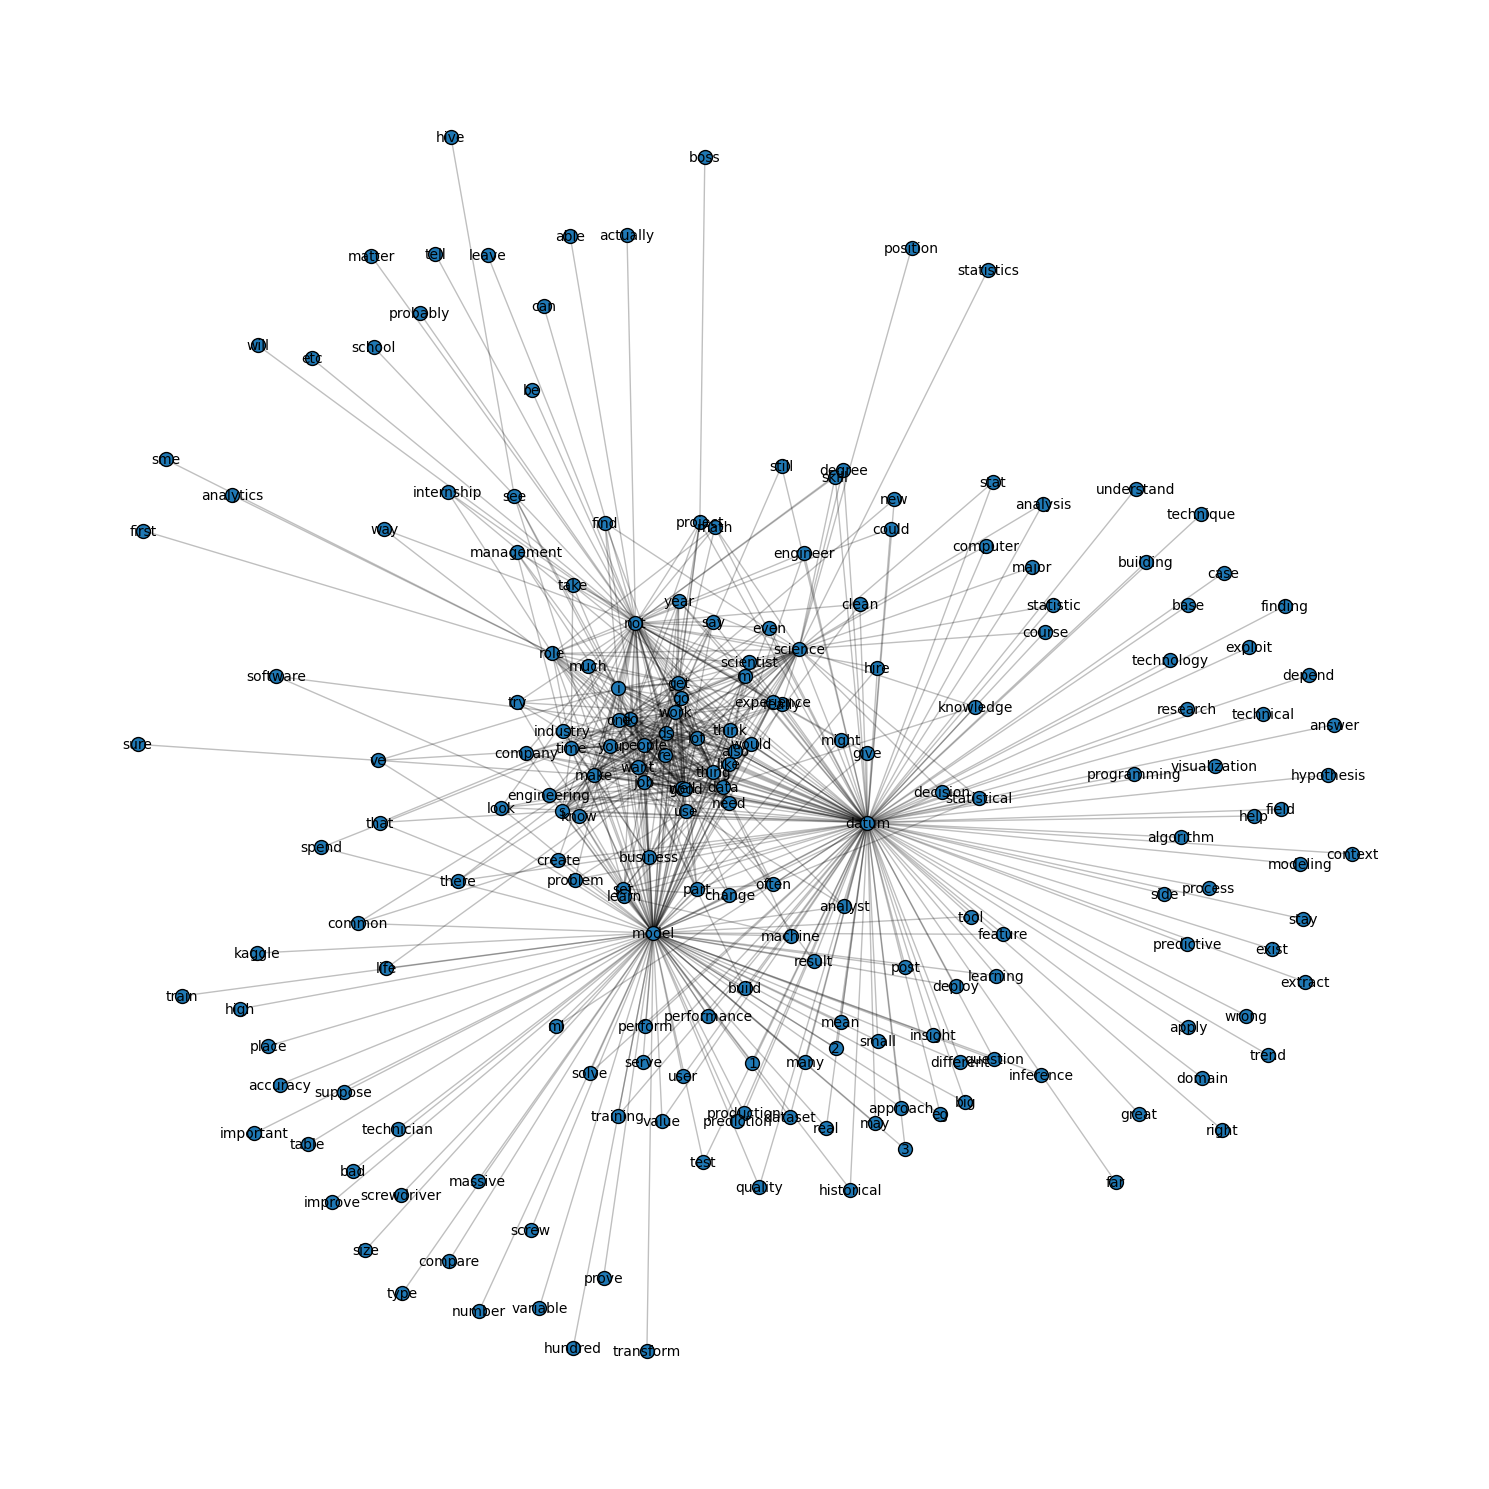

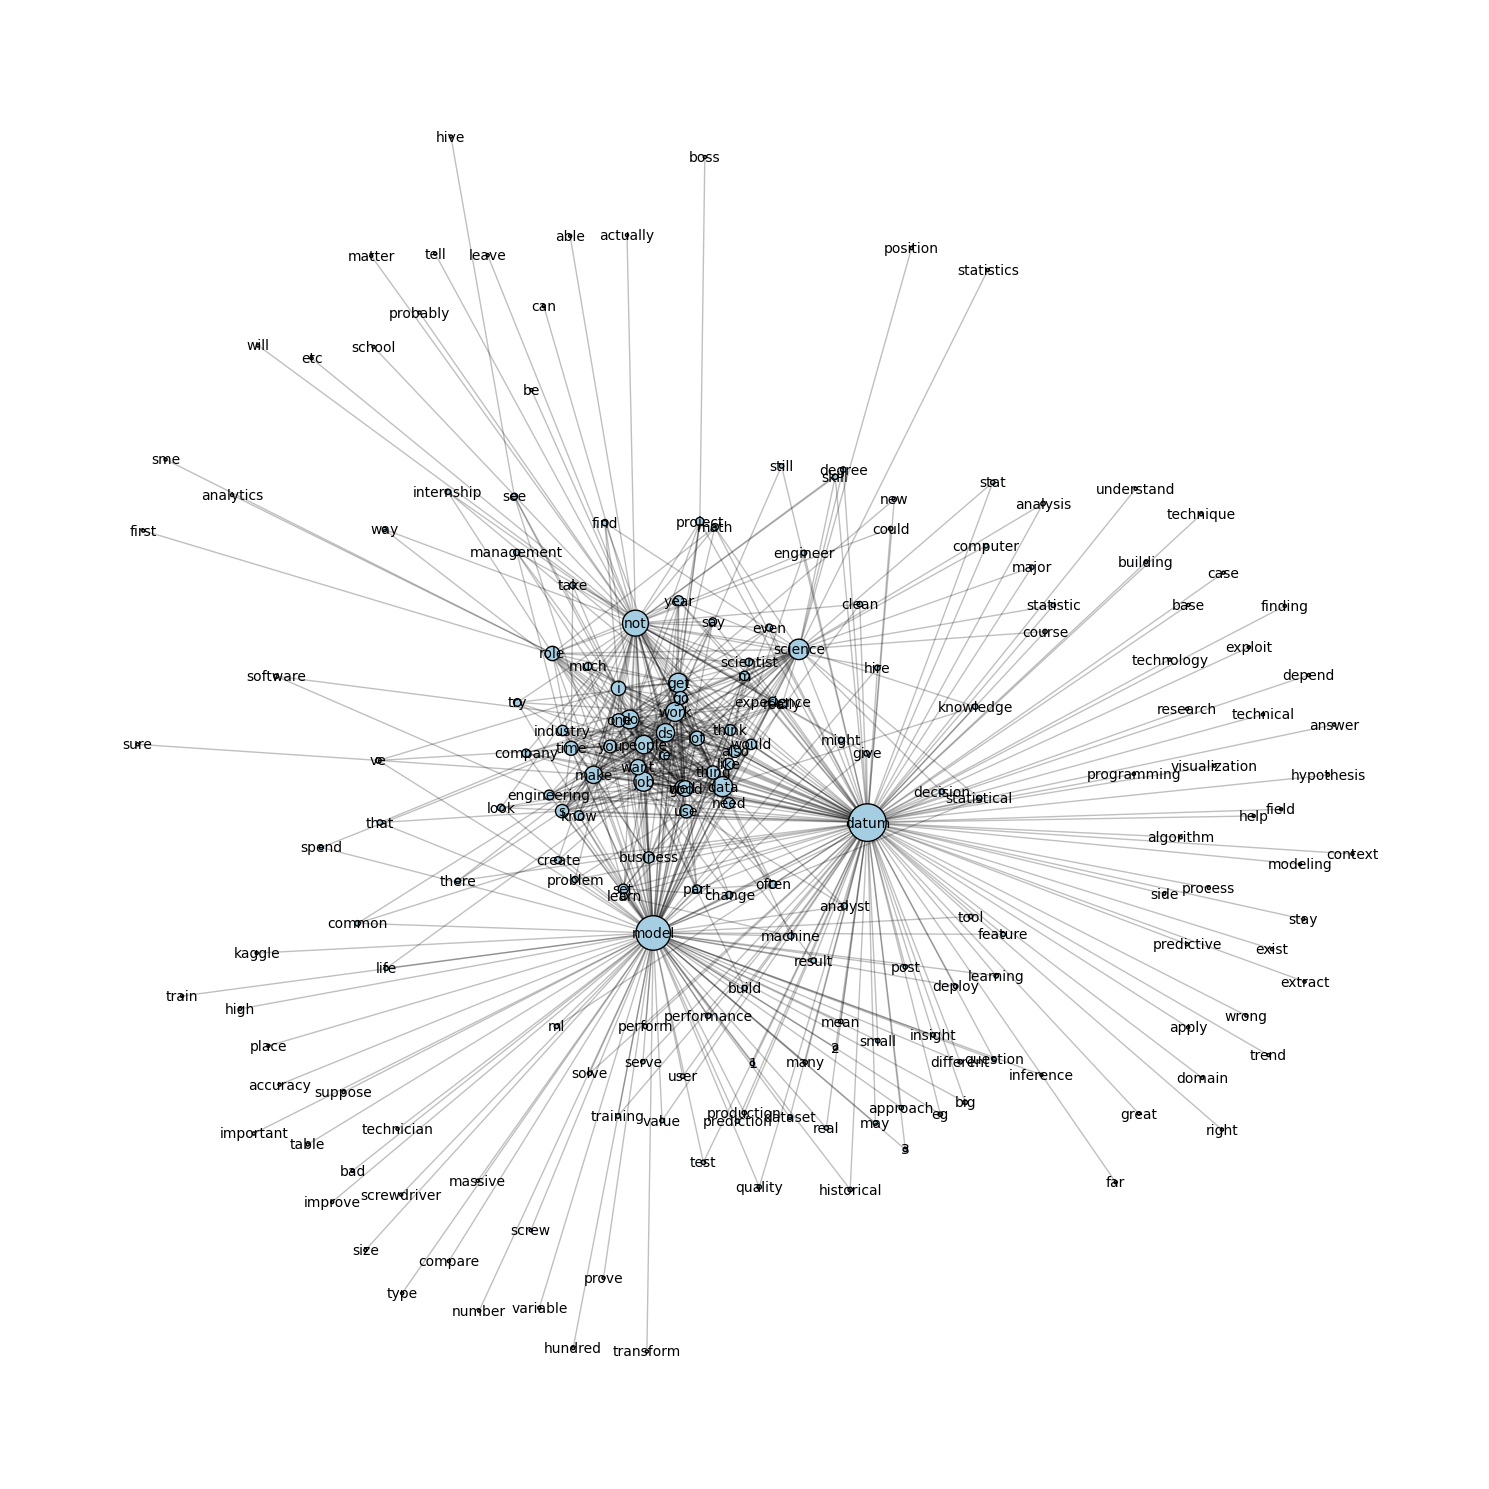

In [ ]:
# prompt: make above plot larger

plt.figure(figsize=(15, 15))  # Increase the figure size for a larger plot

pos = nx.spring_layout(G, seed=200)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)
nx.draw_networkx_nodes(G, pos, node_size=100).set_edgecolor('black')

# Add labels to the nodes
labels = {node: str(node) for node in G.nodes()}  # Replace str(node) with your actual labels
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

plt.tight_layout()
plt.axis("off")
plt.show()

degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

plt.figure(figsize=(15, 15))  # Increase the figure size for a larger plot

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()
